<h2 style="color: blue;"> Part 2: predicting firms' default </h2>

## 

The objective is to build a classifier for whether a firm is going to default. 

In [ ]:
import numpy as np
import pandas as pd
# import patsy

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 

import seaborn as sns
import matplotlib.pyplot as plt

### Load & visualise data

In [ ]:
data = pd.read_csv("../../data/bisnode_firms_clean.csv")

In [ ]:
data.shape

(19036, 118)

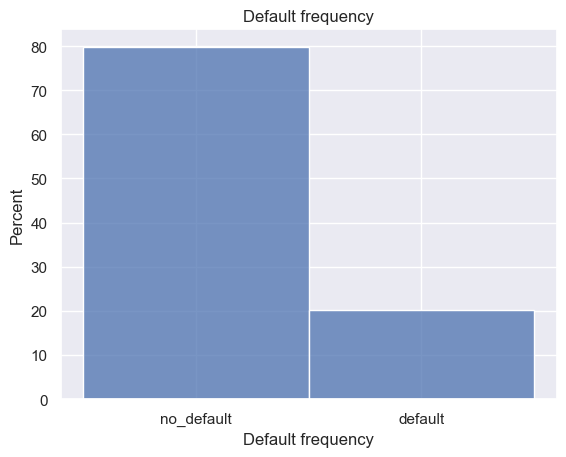

In [ ]:
sns.set_theme()
sns.histplot(data=data, x="default_f", stat="percent") 
plt.title('Default frequency')
plt.xlabel('Default frequency') 
plt.show()

In [ ]:
y=data['default']
X=data.drop(columns='default')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

All sets are balanced:

In [ ]:
print("--- Total ---")
print(y.value_counts(normalize=True))
print("--- Train ---")
print(y_train.value_counts(normalize=True))
print("--- Test ---")
print(y_test.value_counts(normalize=True))

--- Total ---
default
0    0.797857
1    0.202143
Name: proportion, dtype: float64
--- Train ---
default
0    0.799958
1    0.200042
Name: proportion, dtype: float64
--- Test ---
default
0    0.791553
1    0.208447
Name: proportion, dtype: float64


### Model building

There are so many variables !

We are going to compare several models : 
- Logit with a selection of variables **M1**
- Logit with a selection of variables **M2**
- Regularized logit on **M2** variables

Firm related variables

In [ ]:
firm = ["age", "age2", "new", "ind2_cat", "m_region_loc", "urban_m"]

Human capital related variables

In [ ]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

Financial variables

In [ ]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]

engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]

Growth variables

In [ ]:
d1 = [ 
    "d1_sales_mil_log_mod",
    "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log",
    "flag_high_d1_sales_mil_log",
]

In [ ]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "age",
    "foreign_management",
    "ind2_cat",
]
M2 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar + d1 + hr
len(M2)

36

#### Selection of the relevant variables

In [ ]:
# M1
X_train_M1=X_train[M1]
X_test_M1 =X_test[M1]

In [ ]:
# M2
X_train_M2=X_train[M2]
X_test_M2 =X_test[M2]

#### Set up the method for model selection

In [ ]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

#### No regularisation needed so setting the paremeter to very high value

In [ ]:
C_value_logit = [1e20]

#### Where we put the results of the different models, for comparison purposes:

In [ ]:
test_accuracy={}
test_auc_roc={}

### Model 1: Logit
#### Set up Logit model object

In [ ]:
logistic = LogisticRegressionCV(
    Cs=C_value_logit,   #  # Cs: inverse of regularization strength.
    cv=k,               # 5-fold cross-validation
    refit=True,         # Refit the best estimator with the entire dataset
    solver="newton-cg", # Optimization algorithm
    tol=1e-7,           # Tolerance for stopping criteria
    random_state=42,    # Random seed
)

#### Creating the pipeline

In [ ]:
pipeline_logit = Pipeline([
    ('standardize', StandardScaler()),
    ('log_reg', logistic)
                          ])
pipeline_logit

Pipeline(steps=[('standardize', StandardScaler()),
                ('log_reg',
                 LogisticRegressionCV(Cs=[1e+20],
                                      cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                      random_state=42, solver='newton-cg',
                                      tol=1e-07))])

#### On M1 features set

In [ ]:
pipeline_logit.fit(X_train_M1, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('log_reg',
                 LogisticRegressionCV(Cs=[1e+20],
                                      cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                      random_state=42, solver='newton-cg',
                                      tol=1e-07))])

In [ ]:
# Predictions on the test set
y_test_hat = pipeline_logit.predict(X_test_M1)
y_test_hat_probs = pipeline_logit.predict_proba(X_test_M1)[:,1]

# Metrics
test_accuracy['logit_m1'] = accuracy_score(y_test, y_test_hat)*100
test_auc_roc['logit_m1'] = roc_auc_score(y_test, y_test_hat_probs)*100

print('Confusion matrix:\n', confusion_matrix(y_test, y_test_hat))
print('Testing AUC: %.4f %%' % test_auc_roc['logit_m1'])
print('Testing accuracy: %.4f %%' % test_accuracy['logit_m1']) 


Confusion matrix:
 [[3615  152]
 [ 786  206]]
Testing AUC: 76.5941 %
Testing accuracy: 80.2900 %


#### On M2 features set

We need to deal with all the features: depending on their type, the pre-processing will be different

##### Categorical features

In [ ]:
from sklearn.compose import make_column_selector as selector 

categorical_columns_selector = selector(dtype_include=object)  # Selects all columns of type object
categorical_features = categorical_columns_selector(X_train_M2) # Apply the selector to the training set
categorical_features

['m_region_loc']

In [ ]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
categorical_transformer

Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

##### Numeric features

In [ ]:
numeric_features = [col for col in X_train_M2.columns if col not in categorical_features] # Select the columns that are not categorical
len(numeric_features)

35

In [ ]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
numeric_transformer

Pipeline(steps=[('scaler', StandardScaler())])

In [ ]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['sales_mil_log', 'sales_mil_log_sq', 'age',
                                  'age2', 'new', 'ind2_cat', 'urban_m',
                                  'total_assets_bs', 'fixed_assets_bs',
                                  'liq_assets_bs', 'curr_assets_bs',
                                  'share_eq_bs', 'subscribed_cap_bs',
                                  'intang_assets_bs', 'extra_exp_pl',
                                  'extra_inc_pl', 'extra_profit_loss_pl',
                                  'inc_bef_tax_pl', 'inventories_pl',
                                  'material_exp_pl', 'profit_loss_year_pl',
                                  'personnel_exp_pl', 'd1_sales_mil_log_mod',
                                  'd1_sales_mil_log_mod_sq',
                                  'flag_low_d1_sales_mil_log',
                                  'flag_high_d1_sales_mil_log', 'female',
                                  'ceo_age', 'flag_high_ceo_age',
                                  'flag_low_ceo_age', ...]),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['m_region_loc'])])

##### The pipeline:

In [ ]:
#Append classifier to preprocessing pipeline. Now we have a full prediction pipeline.
pipeline_logit = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", logistic)]
)
pipeline_logit

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['sales_mil_log',
                                                   'sales_mil_log_sq', 'age',
                                                   'age2', 'new', 'ind2_cat',
                                                   'urban_m', 'total_assets_bs',
                                                   'fixed_assets_bs',
                                                   'liq_assets_bs',
                                                   'curr_assets_bs',
                                                   'share_eq_bs',
                                                   'subscribed_cap_bs',
                                                   'intang_assets_bs',
                                                   'extra_exp_pl',
                                                   'extra_inc_pl',
                                                   'extr...
                                                   'flag_low_d1_sales_mil_log',
                                                   'flag_high_d1_sales_mil_log',
                                                   'female', 'ceo_age',
                                                   'flag_high_ceo_age',
                                                   'flag_low_ceo_age', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['m_region_loc'])])),
                ('classifier',
                 LogisticRegressionCV(Cs=[1e+20],
                                      cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                      random_state=42, solver='newton-cg',
                                      tol=1e-07))])

<div class="alert alert-info">
<h4> Your turn: Fit the pipeline </h4>
Following M1 example, estimate and evaluate a logit model with cross-validation using the M2 set of features.     
</div>

In [ ]:
logistic = LogisticRegressionCV(
    Cs=C_value_logit,   #  # Cs: inverse of regularization strength.
    cv=k,               # 5-fold cross-validation
    refit=True,         # Refit the best estimator with the entire dataset
    solver="newton-cg", # Optimization algorithm
    tol=1e-7,           # Tolerance for stopping criteria
    random_state=42,    # Random seed
)

In [ ]:
pipeline_logit.fit(X_train_M2, y_train)

y_train_hat = pipeline_logit.predict(X_train)
y_train_proba_hat = pipeline_logit.predict_proba(X_train)


##### Performances for M2

#### Comparing performance for the 2 logit models: 

In [ ]:
test_auc_roc

{'logit_m1': 76.59411742038243}

In [ ]:
test_accuracy

{'logit_m1': 80.28997688590039}

### Model 2: Lasso with standardized X data

In [ ]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3)) # 10^-1, 10^-0.67, 10^-0.33, 10^0, 10^0.33, 10^0.67, 10^1
n_obs = X_train_M2.shape[0] * 4 / 5 # 4/5 of the training set
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength
len(C_values)

10

In [ ]:
logistic_lasso = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1", # L1 regularization = lasso 
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)


<div class="alert alert-info">
<h4> Your turn: Create and implement the pipeline with the logistic lasso </h4>
</div>

In [ ]:
#Append classifier to preprocessing pipeline. Now we have a full prediction pipeline.

In [ ]:
pipeline_logistic_lasso =

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
# k = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_logistic_lasso, X_train_M2, y_train, cv = k)

NameError: name 'pipeline_logistic_lasso' is not defined

In [ ]:
y_test_hat = pipeline_logistic_lasso.predict(X_test_M2)
y_test_hat_probs = pipeline_logistic_lasso.predict_proba(X_test_M2)[:,1]

NameError: name 'pipeline_logistic_lasso' is not defined

In [ ]:
test_accuracy['logistic_lasso'] = accuracy_score(y_test, y_test_hat)*100
test_auc_roc['logistic_lasso'] = roc_auc_score(y_test, y_test_hat_probs)*100

In [ ]:
from sklearn import metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_hat_probs)
roc_auc = metrics.auc(fpr, tpr)
threshold

In [ ]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Comparing the models

In [ ]:
test_auc_roc

In [ ]:
test_accuracy

#### Deciding on the model

`logit_m2` seems to perform marginaly better on the test set. 

### Re-estimating the model on the full dataset

In [ ]:
#Append classifier to preprocessing pipeline. Now we have a full prediction pipeline.
pipeline_logit = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", logistic)]
)
pipeline_logit

In [ ]:
X_M2 = X[M2]

In [ ]:
logLasso=pipeline_logit.fit(X_M2, y)
logLasso

### Using the model 

In [ ]:
#y_new_hat = logLasso.predict(X_new)

## Going further